# references
https://docs.langchain.com/oss/python/langchain/multi-agent/handoffs-customer-support

In this tutorial, you’ll build a customer support agent that does the following:
- Collects warranty information before proceeding.
- Classifies issues as hardware or software.
- Provides solutions or escalates to human support.
- Maintains conversation state across multiple turns.

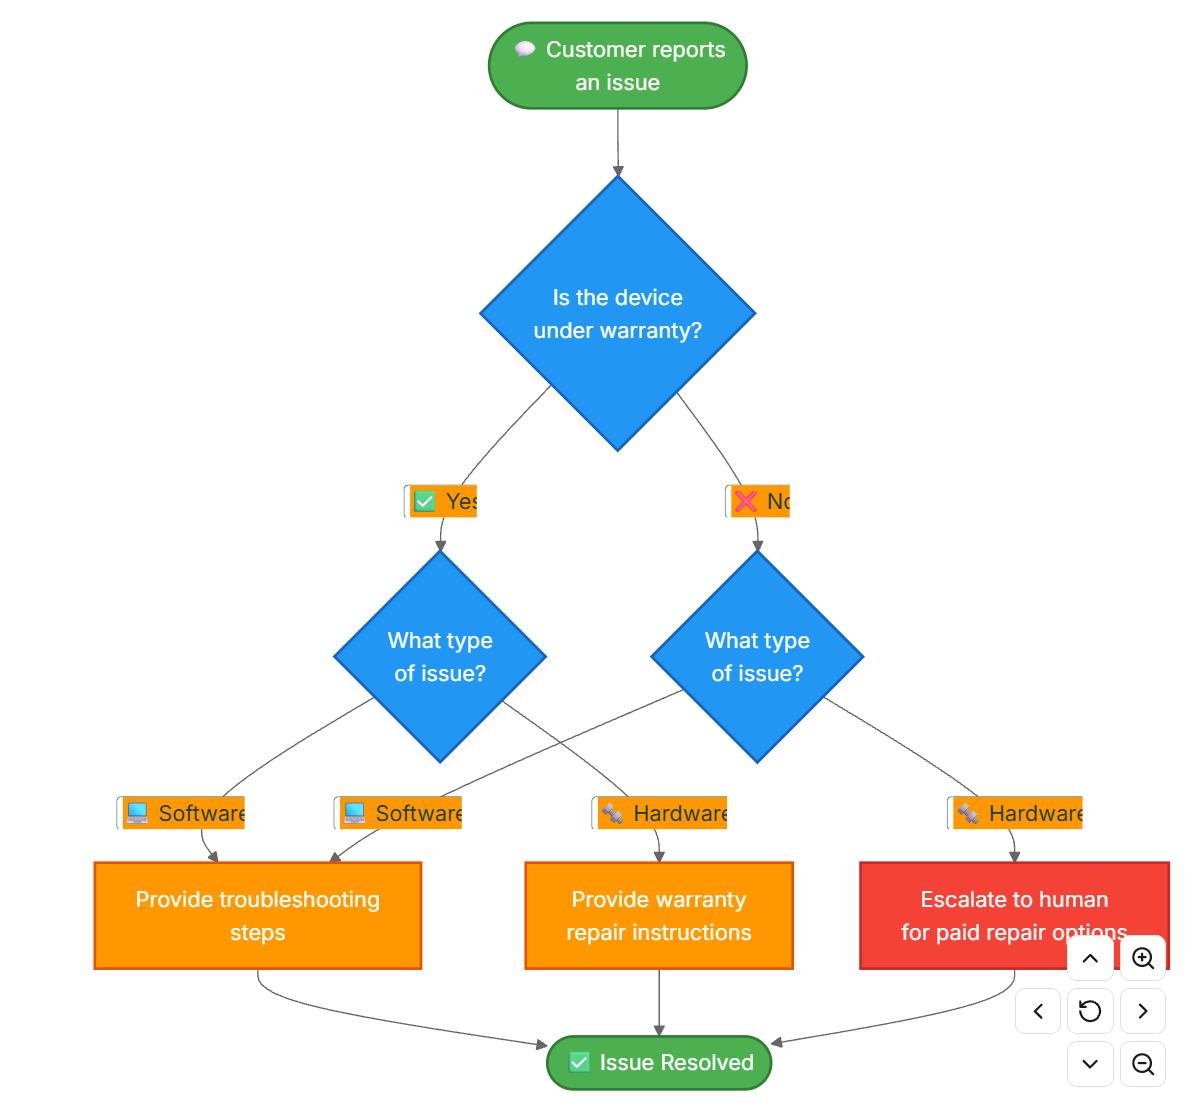

In [1]:
from dotenv import load_dotenv

load_dotenv()

True

In [2]:
# create Embedding function using Ollama
from langchain_ollama import OllamaEmbeddings

embeddings = OllamaEmbeddings(
    model="qwen3-embedding:0.6b",
    base_url="https://chat.ilawyer.com.vn/ollama")

In [2]:
# define LLM model first
import os

from langchain_openai import ChatOpenAI
model = ChatOpenAI(model="qwen3:30b",
                 api_key=os.getenv("OPEN_WEBUI_OPENAI_KEY"), 
                 base_url=os.getenv("OPEN_WEBUI_OPENAI_URL"),
                 temperature=0.5)

In [4]:
# Create Qdrant client
from langchain_qdrant import QdrantVectorStore
from qdrant_client import QdrantClient

qdrant_client = QdrantClient(
            url = os.getenv("QDRANT_URL"),
            port = 80,
            https = False,
            api_key = os.getenv("QDRANT_API_KEY"),
        )

/tmp/ipykernel_628198/2594988558.py:5: UserWarning: Api key is used with an insecure connection.
  qdrant_client = QdrantClient(


In [ ]:
# create collection in Qdrant
from qdrant_client.http.models import Distance, VectorParams

qdrant_client.create_collection(
    collection_name="20260118_semantic_search_collection",
    vectors_config=VectorParams(size=1024, distance=Distance.COSINE),
)

In [5]:
# Create the Qdrant vector store
vector_store = QdrantVectorStore(
    client=qdrant_client,
    collection_name="20260118_semantic_search_collection",
    embedding=embeddings,
)

In [3]:
# define custom sate
from langchain.agents import AgentState
from typing_extensions import NotRequired
from typing import Literal

# Define the possible workflow steps
SupportStep = Literal["warranty_collector", "issue_classifier", "resolution_specialist"]  

class SupportState(AgentState):  
    """State for customer support workflow."""
    current_step: NotRequired[SupportStep]  
    warranty_status: NotRequired[Literal["in_warranty", "out_of_warranty"]]
    issue_type: NotRequired[Literal["hardware", "software"]]

In [4]:
# create tools that manage workflow state
from langchain.tools import tool, ToolRuntime
from langchain.messages import ToolMessage
from langgraph.types import Command

@tool
def record_warranty_status(
    status: Literal["in_warranty", "out_of_warranty"],
    runtime: ToolRuntime[None, SupportState],
) -> Command:  
    """Record the customer's warranty status and transition to issue classification."""
    # use Command to update state and messages
    return Command(
        update={  
            "messages": [
                ToolMessage(
                    content=f"Warranty status recorded as: {status}",
                    tool_call_id=runtime.tool_call_id,
                )
            ],
            "warranty_status": status,
            "current_step": "issue_classifier",  
        }
    )


@tool
def record_issue_type(
    issue_type: Literal["hardware", "software"],
    runtime: ToolRuntime[None, SupportState],
) -> Command:  
    """Record the type of issue and transition to resolution specialist."""
    return Command(  
        update={  
            "messages": [
                ToolMessage(
                    content=f"Issue type recorded as: {issue_type}",
                    tool_call_id=runtime.tool_call_id,
                )
            ],
            "issue_type": issue_type,
            "current_step": "resolution_specialist",  
        }
    )


@tool
def escalate_to_human(reason: str) -> str:
    """Escalate the case to a human support specialist."""
    # In a real system, this would create a ticket, notify staff, etc.
    return f"Escalating to human support. Reason: {reason}"


@tool
def provide_solution(solution: str) -> str:
    """Provide a solution to the customer's issue."""
    return f"Solution provided: {solution}"

In [5]:
# Define step configurations

# Define prompts as constants for easy reference
WARRANTY_COLLECTOR_PROMPT = """You are a customer support agent helping with device issues.

CURRENT STAGE: Warranty verification

At this step, you need to:
1. Greet the customer warmly
2. Ask if their device is under warranty
3. Use record_warranty_status to record their response and move to the next step

Be conversational and friendly. Don't ask multiple questions at once."""

ISSUE_CLASSIFIER_PROMPT = """You are a customer support agent helping with device issues.

CURRENT STAGE: Issue classification
CUSTOMER INFO: Warranty status is {warranty_status}

At this step, you need to:
1. Ask the customer to describe their issue
2. Determine if it's a hardware issue (physical damage, broken parts) or software issue (app crashes, performance)
3. Use record_issue_type to record the classification and move to the next step

If unclear, ask clarifying questions before classifying."""

RESOLUTION_SPECIALIST_PROMPT = """You are a customer support agent helping with device issues.

CURRENT STAGE: Resolution
CUSTOMER INFO: Warranty status is {warranty_status}, issue type is {issue_type}

At this step, you need to:
1. For SOFTWARE issues: provide troubleshooting steps using provide_solution
2. For HARDWARE issues:
   - If IN WARRANTY: explain warranty repair process using provide_solution
   - If OUT OF WARRANTY: escalate_to_human for paid repair options

Be specific and helpful in your solutions."""

# Step configuration: maps step name to (prompt, tools, required_state)
STEP_CONFIG = {
    "warranty_collector": {
        "prompt": WARRANTY_COLLECTOR_PROMPT,
        "tools": [record_warranty_status],
        "requires": [],
    },
    "issue_classifier": {
        "prompt": ISSUE_CLASSIFIER_PROMPT,
        "tools": [record_issue_type],
        "requires": ["warranty_status"],
    },
    "resolution_specialist": {
        "prompt": RESOLUTION_SPECIALIST_PROMPT,
        "tools": [provide_solution, escalate_to_human],
        "requires": ["warranty_status", "issue_type"],
    },
}

In [6]:
# Create step-based middleware

from langchain.agents.middleware import wrap_model_call, ModelRequest, ModelResponse
from typing import Callable

@wrap_model_call
def apply_step_config(
    request: ModelRequest,
    handler: Callable[[ModelRequest], ModelResponse],
) -> ModelResponse:
    """Configure agent behavior based on the current step."""
    # Get current step (defaults to warranty_collector for first interaction)
    current_step = request.state.get("current_step", "warranty_collector")  

    # Look up step configuration
    stage_config = STEP_CONFIG[current_step]  

    # Validate required state exists
    for key in stage_config["requires"]:
        if request.state.get(key) is None:
            raise ValueError(f"{key} must be set before reaching {current_step}")

    # Format prompt with state values (supports {warranty_status}, {issue_type}, etc.)
    system_prompt = stage_config["prompt"].format(**request.state)

    # Inject system prompt and step-specific tools
    request = request.override(  
        system_prompt=system_prompt,  
        tools=stage_config["tools"],  
    )

    return handler(request)

In [7]:
# Create the agent with step-based middleware
from langchain.agents import create_agent
from langgraph.checkpoint.memory import InMemorySaver

# Collect all tools from all step configurations
all_tools = [
    record_warranty_status,
    record_issue_type,
    provide_solution,
    escalate_to_human,
]

# Create the agent with step-based configuration
agent = create_agent(
    model,
    tools=all_tools,
    state_schema=SupportState,  
    middleware=[apply_step_config],  
    checkpointer=InMemorySaver(),
)


In [8]:
# test the workflow agent
from langchain.messages import HumanMessage
import uuid

# Configuration for this conversation thread
thread_id = str(uuid.uuid4())
config = {"configurable": {"thread_id": thread_id}}

# Turn 1: Initial message - starts with warranty_collector step
print("=== Turn 1: Warranty Collection ===")
result = agent.invoke(
    {"messages": [HumanMessage("Hi, my phone screen is cracked")]},
    config
)
for msg in result['messages']:
    msg.pretty_print()

# Turn 2: User responds about warranty
print("\n=== Turn 2: Warranty Response ===")
result = agent.invoke(
    {"messages": [HumanMessage("Yes, it's still under warranty")]},
    config
)
for msg in result['messages']:
    msg.pretty_print()
print(f"Current step: {result.get('current_step')}")

# Turn 3: User describes the issue
print("\n=== Turn 3: Issue Description ===")
result = agent.invoke(
    {"messages": [HumanMessage("The screen is physically cracked from dropping it")]},
    config
)
for msg in result['messages']:
    msg.pretty_print()
print(f"Current step: {result.get('current_step')}")

# Turn 4: Resolution
print("\n=== Turn 4: Resolution ===")
result = agent.invoke(
    {"messages": [HumanMessage("What should I do?")]},
    config
)
for msg in result['messages']:
    msg.pretty_print()

=== Turn 1: Warranty Collection ===
================================ Human Message =================================

Hi, my phone screen is cracked
================================== Ai Message ==================================

Hi there! Thanks for reaching out. Could you let me know if your device is still under warranty? 😊

=== Turn 2: Warranty Response ===
================================ Human Message =================================

Hi, my phone screen is cracked
================================== Ai Message ==================================

Hi there! Thanks for reaching out. Could you let me know if your device is still under warranty? 😊
================================ Human Message =================================

Yes, it's still under warranty
================================== Ai Message ==================================
Tool Calls:
  record_warranty_status (call_nggrb5k1)
 Call ID: call_nggrb5k1
  Args:
    status: in_warranty
================================= Tool

# Manage message history

In [ ]:
# Manage message history
# add SummarizationMiddleware  to manage long histories in agent workflow
from langchain.agents import create_agent
from langchain.agents.middleware import SummarizationMiddleware  
from langgraph.checkpoint.memory import InMemorySaver

agent = create_agent(
    model,
    tools=all_tools,
    state_schema=SupportState,
    middleware=[
        apply_step_config,
        SummarizationMiddleware(  
            model="gpt-4o-mini",
            trigger=("tokens", 4000),
            keep=("messages", 10)
        )
    ],
    checkpointer=InMemorySaver(),
)

## Advanced function: Add flexibility: Go back

In [ ]:
@tool
def go_back_to_warranty() -> Command:  
    """Go back to warranty verification step."""
    return Command(update={"current_step": "warranty_collector"})  


@tool
def go_back_to_classification() -> Command:  
    """Go back to issue classification step."""
    return Command(update={"current_step": "issue_classifier"})  


# Update the resolution_specialist configuration to include these tools
STEP_CONFIG["resolution_specialist"]["tools"].extend([
    go_back_to_warranty,
    go_back_to_classification
])

In [ ]:
# Update the resolution specialist’s prompt to mention these tools:

RESOLUTION_SPECIALIST_PROMPT = """You are a customer support agent helping with device issues.

CURRENT STAGE: Resolution
CUSTOMER INFO: Warranty status is {warranty_status}, issue type is {issue_type}

At this step, you need to:
1. For SOFTWARE issues: provide troubleshooting steps using provide_solution
2. For HARDWARE issues:
   - If IN WARRANTY: explain warranty repair process using provide_solution
   - If OUT OF WARRANTY: escalate_to_human for paid repair options

If the customer indicates any information was wrong, use:
- go_back_to_warranty to correct warranty status
- go_back_to_classification to correct issue type

Be specific and helpful in your solutions."""

In [ ]:
# Now the agent can handle corrections:

result = agent.invoke(
    {"messages": [HumanMessage("Actually, I made a mistake - my device is out of warranty")]},
    config
)
# Agent will call go_back_to_warranty and restart the warranty verification step